In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

from datetime import datetime, timedelta

import numpy as np
import pandas as pd

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
45 packages can be upgraded. Run 'apt list --upgradable' to see them.
tar: spark-3.2.1-bin-hadoop3.2.tgz: Cannot open: No such file or directory
tar: Error is not recov

In [3]:
################################
appName = 'MarioFreireAriasFinalProject'
spark = SparkSession.builder\
                    .appName(appName) \
                    .getOrCreate()
sc = spark.sparkContext

In [4]:
spark

In [5]:
company_ticker = "UAL"
filename = "ual.csv"

# check the contents of the directory
print(os.listdir())

# load the data from the csv file
combined_data = spark.read.csv(filename, header=True, inferSchema=True)

# rename the columns
combined_data = combined_data.withColumnRenamed("combined_data.cik", "cik") \
       .withColumnRenamed("combined_data.ticker", "ticker") \
       .withColumnRenamed("combined_data.date", "date") \
       .withColumnRenamed("combined_data.open", "open") \
       .withColumnRenamed("combined_data.high", "high") \
       .withColumnRenamed("combined_data.low", "low") \
       .withColumnRenamed("combined_data.close", "close") \
       .withColumnRenamed("combined_data.adjclose", "adjclose") \
       .withColumnRenamed("combined_data.volume", "volume") \
       .withColumnRenamed("combined_data.rn", "rn")

combined_data = combined_data.orderBy("date")
combined_data.show()
combined_data.tail(7)

['.config', 'ual.csv', '.ipynb_checkpoints']
+------+------+----------+-----------------+-----------------+-----------------+-----------------+-----------------+---------+-----+
|   cik|ticker|      date|             open|             high|              low|            close|         adjclose|   volume|   rn|
+------+------+----------+-----------------+-----------------+-----------------+-----------------+-----------------+---------+-----+
|100517|   UAL|2018-01-02| 67.9000015258789|69.01000213623047|67.37999725341797|68.94000244140625|68.94000244140625|3390600.0|98004|
|100517|   UAL|2018-01-03|68.94000244140625|69.37000274658203|67.81999969482422|68.48999786376953|68.48999786376953|4590900.0|98003|
|100517|   UAL|2018-01-04|68.69000244140625|69.37000274658203|67.63999938964844|69.26000213623047|69.26000213623047|3922900.0|98002|
|100517|   UAL|2018-01-05| 69.4000015258789| 69.4000015258789| 68.7699966430664|69.36000061035156|69.36000061035156|2675900.0|98001|
|100517|   UAL|2018-01-0

[Row(cik=100517, ticker='UAL', date=datetime.date(2024, 4, 15), open=42.150001525878906, high=42.83000183105469, low=40.84000015258789, close=41.040000915527344, adjclose=41.040000915527344, volume=10452100.0, rn=631),
 Row(cik=100517, ticker='UAL', date=datetime.date(2024, 4, 16), open=40.79999923706055, high=41.720001220703125, low=40.099998474121094, close=41.5, adjclose=41.5, volume=18510900.0, rn=630),
 Row(cik=100517, ticker='UAL', date=datetime.date(2024, 4, 17), open=44.45000076293945, high=49.13999938964844, low=44.11000061035156, close=48.7400016784668, adjclose=48.7400016784668, volume=67541296.0, rn=629),
 Row(cik=100517, ticker='UAL', date=datetime.date(2024, 4, 18), open=49.220001220703125, high=51.880001068115234, low=49.20000076293945, close=51.41999816894531, adjclose=51.41999816894531, volume=38676000.0, rn=628),
 Row(cik=100517, ticker='UAL', date=datetime.date(2024, 4, 19), open=51.189998626708984, high=53.099998474121094, low=50.900001525878906, close=51.3800010681

In [7]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import year, month, dayofmonth

# Assuming you already have a SparkSession named spark
# Assuming combined_data is your DataFrame with columns 'date' and 'close'

# Extract year, month, and day from the date column
data_with_features = combined_data.withColumn("year", year("date")) \
                                  .withColumn("month", month("date")) \
                                  .withColumn("day", dayofmonth("date"))
data_with_features = data_with_features.orderBy("date")

# Split data into train and test sets (80% train, 20% test)
# Calculate the index to split at (80% train, 20% test)
split_index = int(0.8 * data_with_features.count())

# Split the data into train and test sets
train_data = data_with_features.limit(split_index)
test_data = data_with_features.subtract(train_data)

# Define the features column
feature_columns = ['year', 'month', 'day']
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define the LinearRegression
lr = LinearRegression(featuresCol="features", labelCol="close")  # Assuming you want to predict 'close' based on 'date'

# Create a pipeline
pipeline = Pipeline(stages=[vector_assembler, lr])

# Define parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.2, 0.3, 0.4, 0.5]) \
    .addGrid(lr.maxIter, [5, 7, 10, 12, 20]) \
    .addGrid(lr.elasticNetParam, [0.1, 0.4, 0.8, 0.99]).build()

# Define evaluator
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")

# Create CrossValidator
cross_val = CrossValidator(estimator=pipeline,
                           estimatorParamMaps=param_grid,
                           evaluator=evaluator,
                           numFolds=3)  # You can adjust the number of folds as needed

# Fit the model
cv_model = cross_val.fit(train_data)

# Get best model
best_model = cv_model.bestModel

# Make predictions on the test set
predictions = best_model.transform(test_data)

# Evaluate the model on test data
rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data =", rmse)

Root Mean Squared Error (RMSE) on test data = 21.27180968246922


In [9]:
params = [{p.name: v for p, v in m.items()} for m in cv_model.getEstimatorParamMaps()]
import pandas as pd

results_df = pd.DataFrame.from_dict([
    {cv_model.getEvaluator().getMetricName(): metric, **ps}
    for ps, metric in zip(params, cv_model.avgMetrics)
])

print(results_df)

results_df = results_df.sort_values(by='rmse', ascending=False)


         rmse  regParam  maxIter  elasticNetParam
0   14.663981       0.1        5             0.10
1   14.664317       0.1        5             0.40
2   14.664872       0.1        5             0.80
3   14.665030       0.1        5             0.99
4   14.663982       0.1        7             0.10
..        ...       ...      ...              ...
95  14.671819       0.5       12             0.99
96  14.668820       0.5       20             0.10
97  14.671818       0.5       20             0.40
98  14.671404       0.5       20             0.80
99  14.671819       0.5       20             0.99

[100 rows x 4 columns]


In [10]:
import time
# Split data into train and test sets (80% train, 20% test)
# Calculate the index to split at (80% train, 20% test)
split_index = int(data_with_features.count() - 7)

# Split the data into train and test sets
train_data = data_with_features.limit(split_index)
test_data = data_with_features.subtract(train_data)

# Print length of thest data. Should be 7 days
print("Test data length:", test_data.count())

# Define the features column
feature_columns = ['year', 'month', 'day']  # Assuming these are the features you are using
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define the LinearRegression with the best parameters obtained from cross-validation
best_lr = LinearRegression(featuresCol="features", labelCol="close", regParam=0.1, maxIter=5, elasticNetParam=0.1)

# Create a pipeline
pipeline = Pipeline(stages=[vector_assembler, best_lr])

# Fit the model on the entire dataset except the last 7 days
start_time = time.time()
model = pipeline.fit(train_data)
end_time = time.time()
print("Training time: {:.2f} seconds".format(end_time - start_time))

# Make predictions on the entire dataset
predictions = model.transform(test_data)

# Define evaluator
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="r2")

# Evaluate the model on test data
rmse = evaluator.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("Model results for last 7 days")
print("Root Mean Squared Error (RMSE) on test data =", rmse)
print("Mean Absolute Error (MAE) on test data =", mae)
print("R-squared (R2) on test data =", r2)

Test data length: 7
Training time: 0.92 seconds
Model results for last 7 days
Root Mean Squared Error (RMSE) on test data = 17.332869214874048
Mean Absolute Error (MAE) on test data = 16.562523953946634
R-squared (R2) on test data = -10.702817852021266


In [11]:
predictions.show()

+------+------+----------+------------------+------------------+------------------+------------------+------------------+-----------+---+----+-----+---+-----------------+------------------+
|   cik|ticker|      date|              open|              high|               low|             close|          adjclose|     volume| rn|year|month|day|         features|        prediction|
+------+------+----------+------------------+------------------+------------------+------------------+------------------+-----------+---+----+-----+---+-----------------+------------------+
|100517|   UAL|2024-04-15|42.150001525878906| 42.83000183105469| 40.84000015258789|41.040000915527344|41.040000915527344|  1.04521E7|631|2024|    4| 15|[2024.0,4.0,15.0]| 32.34994949163229|
|100517|   UAL|2024-04-16| 40.79999923706055|41.720001220703125|40.099998474121094|              41.5|              41.5|  1.85109E7|630|2024|    4| 16|[2024.0,4.0,16.0]| 32.33225691466396|
|100517|   UAL|2024-04-17| 44.45000076293945| 49.1

In [12]:
test_data = test_data.orderBy("date")
test_data.show()

+------+------+----------+------------------+------------------+------------------+------------------+------------------+-----------+---+----+-----+---+
|   cik|ticker|      date|              open|              high|               low|             close|          adjclose|     volume| rn|year|month|day|
+------+------+----------+------------------+------------------+------------------+------------------+------------------+-----------+---+----+-----+---+
|100517|   UAL|2024-04-15|42.150001525878906| 42.83000183105469| 40.84000015258789|41.040000915527344|41.040000915527344|  1.04521E7|631|2024|    4| 15|
|100517|   UAL|2024-04-16| 40.79999923706055|41.720001220703125|40.099998474121094|              41.5|              41.5|  1.85109E7|630|2024|    4| 16|
|100517|   UAL|2024-04-17| 44.45000076293945| 49.13999938964844| 44.11000061035156|  48.7400016784668|  48.7400016784668|6.7541296E7|629|2024|    4| 17|
|100517|   UAL|2024-04-18|49.220001220703125|51.880001068115234| 49.20000076293945

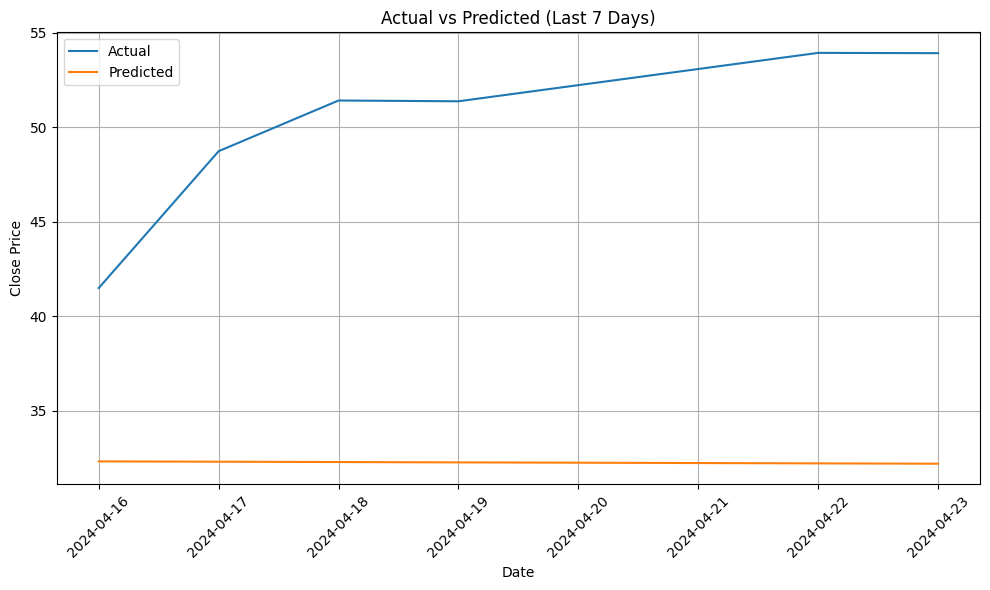

In [13]:
import matplotlib.pyplot as plt
import pandas as pd


# Assuming predictions is the DataFrame containing 'date', 'close' (actual), and 'prediction' columns

# Filter test predictions for the last 7 days
last_7_days_predictions = predictions.filter(predictions['date'] >= predictions.agg({"date": "max"}).collect()[0][0] - pd.Timedelta(days=7))

# Convert Spark DataFrame to Pandas DataFrame for plotting
last_7_days_pd = last_7_days_predictions.select('date', 'close', 'prediction').toPandas()

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(last_7_days_pd['date'], last_7_days_pd['close'], label='Actual')
plt.plot(last_7_days_pd['date'], last_7_days_pd['prediction'], label='Predicted')
plt.title('Actual vs Predicted (Last 7 Days)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()